In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# Get the data

In [69]:
Africa_data = pd.read_csv("Africa_data.txt", sep="\t", header=0)
Africa_data.head()

/var/folders/65/60x1_snj20l20780r6ptdn0h0000gn/T/ipykernel_28063/2689870396.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  Africa_data = pandas.read_csv("Africa_data.txt", sep="\t", header=0)


,name,n.gps,abs_max_lat,abs_min_lat,length_lat,median_lon,median_lat,area,bio1m,bio1sd,...,bio17sd,bio18m,bio18sd,bio19m,bio19sd,elevm,elevsd,continents,dist,Red.List.status
0,Aaronsohnia pubescens,31,35.166667,26.150000,9.016667,-6.317847,31.450001,8.471561e+11,179.645161,21.021494,...,9.050634,14.032258,8.734926,67.806452,45.120889,104.870968,72.551472,"Africa,Europe",global,NaN
1,Abelmoschus esculentus,37,16.016667,25.670000,41.686667,11.516667,6.866667,1.608146e+13,256.918919,30.402283,...,37.179158,272.243243,207.168531,335.540541,478.145468,145.351351,68.946121,"Africa,Asia,Europe,Australia,South America and...",global,NaN
2,Abelmoschus ficulneus,5,15.125000,16.966670,32.091670,37.033333,5.350000,3.643061e+11,270.800000,12.029131,...,25.812788,307.400000,312.333636,142.200000,267.300767,104.400000,59.672439,"Africa,Asia,NA,Australia",global,NaN
3,Abelmoschus manihot,11,9.350000,22.025600,31.375600,11.450000,4.150000,2.084726e+12,236.454545,26.526830,...,42.956849,294.727273,107.079495,596.545455,471.006659,134.636364,68.026866,"Africa,Asia,NA,Australia,South America and the...",global,NaN
4,Abelmoschus moschatus,19,31.182780,16.333333,47.516113,2.550000,6.490000,1.757908e+13,247.947368,51.744537,...,100.923832,369.052632,325.903782,286.526316,246.123359,137.894737,85.452322,"Africa,NA,Asia,Europe,Australia,South America ...",global,NaN


# Change Red List Status Labelling

In [70]:
# Condition to identify rows where 'Red.List.status' is "LR/nt"
condition = Africa_data['Red.List.status'] == "LR/nt"

# Modify the values based on the condition
Africa_data.loc[condition, 'Red.List.status'] = "NT"

# Condition to identify rows where 'Red.List.status' is "LR/nt"
condition = Africa_data['Red.List.status'] == "LR/cd"

# Modify the values based on the condition
Africa_data.loc[condition, 'Red.List.status'] = "VU"

# Condition to identify rows where 'Red.List.status' is "LR/nt"
condition = Africa_data['Red.List.status'] == "LR/lc"

# Modify the values based on the condition
Africa_data.loc[condition, 'Red.List.status'] = "LC"

# Remove some rows

In [71]:
# remove rows without a defined red list status
filtered_Africa_data = Africa_data.dropna(subset=['Red.List.status'])

# remove rows with fewer than 4 samples
filtered_Africa_data = filtered_Africa_data[filtered_Africa_data['n.gps'] >= 4]


# See how many observations belong in each category

In [72]:
status_counts = filtered_Africa_data['Red.List.status'].value_counts().reset_index()

# Rename the columns for clarity
status_counts.columns = ['Red List Status', 'Count']

# Display the table
print(status_counts)

  Red List Status  Count
0              LC    984
1              VU    543
2              EN    388
3              NT    166
4              CR    114
5              DD     51


# Add variable indicating whether a species is LC or not LC

In [73]:
filtered_Africa_data['Response'] = np.where(filtered_Africa_data['Red.List.status'] == 'LC', 'LC', 'NonLC')

# Prepare dataset for training

In [74]:
# List of columns to remove
columns_to_remove = ['name', 'n.gps', 'continents', 'dist', 'Red.List.status']

# Removing columns using drop()
X = filtered_Africa_data.drop(columns=columns_to_remove)

# separe labels and features
y = X['Response']
X = X.drop('Response', axis=1)
X.head()

# Split the dataset into training, testing, and validation sets
# NOTE: DO NOT TOUCH THE TESTING SET 
# NOTE: DO NOT CHANGE THESE RANDOM_STATE VARIABLES
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=40)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=40)

# Scale

In [86]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# Fit, and check OOB Score

In [87]:
randomforest = RandomForestClassifier(n_estimators=1000, oob_score=True)
randomforest.fit(X_train_scaled, y_train)
print(randomforest.oob_score_)

0.8173719376391982


# Make Predictions

Accuracy: 0.82


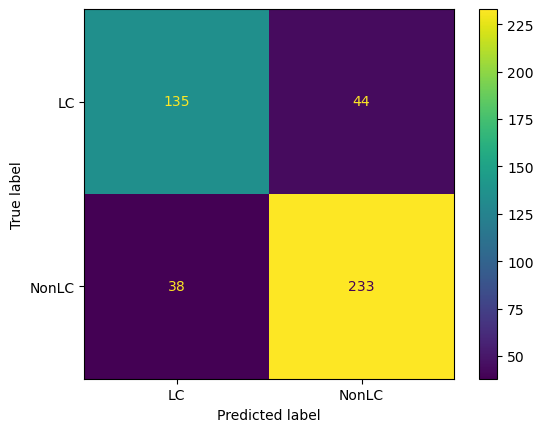

In [88]:
# Make predictions
y_pred_val = randomforest.predict(X_val_scaled)

# Fit the model
accuracy = accuracy_score(y_val, y_pred_val)

# Check accuracy
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_val)

print(f'Accuracy: {accuracy:.2f}')

ConfusionMatrixDisplay.from_estimator(
    randomforest, X_val_scaled, y_val)

# Impurity variable Importance

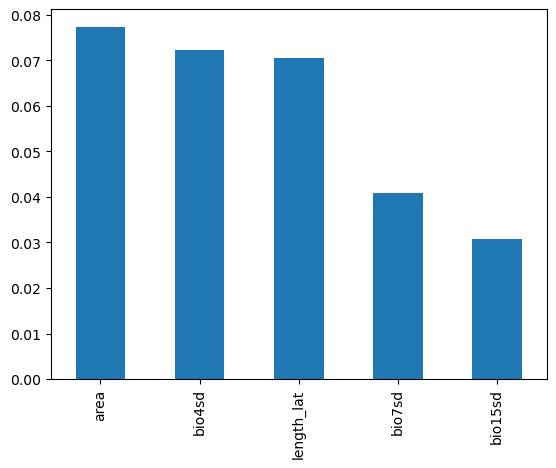

In [97]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(randomforest.feature_importances_, index=X_train.columns).sort_values(ascending=False)[0:5]

# Plot a simple bar chart
feature_importances.plot.bar();

# Permutation Variable Importance

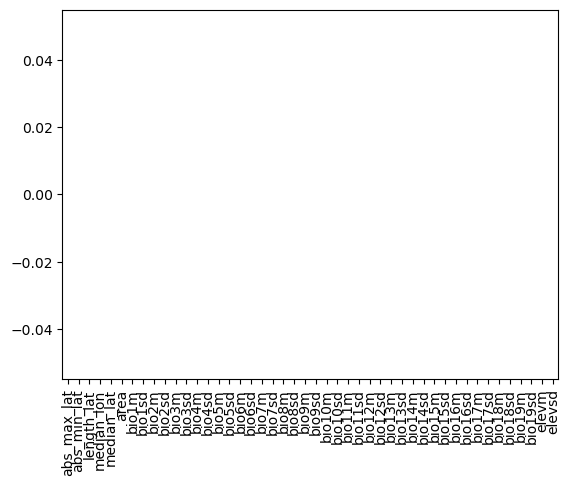

In [96]:
permutation_feature_importances = permutation_importance(randomforest, X_train_scaled, y_train,
                                        n_repeats=30,
                                        random_state=0)

# Create a series containing feature importances from the model and feature names from the training data
plot_permutation_feature_importances = pd.Series(permutation_feature_importances['importances_mean'], index=X_train.columns).sort_values(ascending=False)[0:5]

# Plot a simple bar chart
plot_permutation_feature_importances.plot.bar();